In [1]:
#Satellite Orbiting Earth Example with frame on Earth
using LinearAlgebra
using Plots
using BenchmarkTools
using SatelliteDynamics
using StaticArrays
using Interact

const G = 6.67430e-20 #km**3/(kg * s**2)
const m_1 = 5.97219e24 #mass of the Earth in kg
const m_2 = 1 #mass of satellite in kg
const μ = G*m_1
const R_earth = 6378.12 # in km
h = 1 #time step in seconds

WebIO._IJuliaInit()

1

In [2]:
function sat_dynamics(x)
    
    sat_pose = SA[x[1], x[2], x[3]]
    
    #This WORKS
    upperleft = @SMatrix zeros(3,3)
    upperright = SMatrix{3,3}(1.0I)
    lowerleft = SMatrix{3,3}(1I)*(-μ/(norm(sat_pose))^3)
    lowerright = @SMatrix zeros(3,3)
    
    
    upper = [upperleft upperright]
    lower = [lowerleft lowerright]
    
    A = [upper; lower]
    
    xdot = A*x
    
    return xdot
    
end

sat_dynamics (generic function with 1 method)

In [3]:
function RK4_orbit(x, h)
    
    f1 = sat_dynamics(x)
    f2 = sat_dynamics(x+0.5*h*f1)
    f3 = sat_dynamics(x+0.5*h*f2)
    f4 = sat_dynamics(x+h*f3)
    
    xnext = x+(h/6.0)*(f1+2*f2+2*f3+f4)

    return xnext
    
end

RK4_orbit (generic function with 1 method)

In [4]:
function twobody_rk4(fun, x0, Tf, h)
    
    t = Array(range(0,Tf, step=h)) #create a range to final time at constant time step
    
    all_x = zeros(length(x0), length(t)) #variable to store all x
    
    all_x[:,1] .= x0 #set the initial state
    
    for k=1:(length(t) - 1)
        all_x[:,k+1] .= RK4_orbit(all_x[:,k], h)
    end
    
    return all_x, t
end

twobody_rk4 (generic function with 1 method)

In [5]:
#Tag position
#equator position in cartesian coordinates
#tag =[-6.128804e6, -1.590206e6, 776.1502e3]
#Equitorial position
tag_geof = [-165.4545, 0, 0]

#North pole position
#tag_geof = [-165.4545, 46.98849, 0]

tag = sGEOCtoECEF(tag_geof, use_degrees = true)
    
#Equitorial Position
#In m
x0= tag[1]*1e-3
y0 = tag[2]*1e-3
z0 = tag[3]*1e-3
t0 = 1e-5

r0 = [x0, y0, z0, t0]

4-element Vector{Float64}:
 -6173.708155673107
 -1601.861167312689
     0.0
     1.0e-5

In [6]:
# # #Plot the Earth
# n = 100
# u = range(-π, π; length = n)
# v = range(0, π; length = n)
# x = cos.(u) * sin.(v)'
# y = sin.(u) * sin.(v)' 
# z = ones(n) * cos.(v)' 


# plotly()
# p = surface(x*6371, y*6371, z*6371, color = "blue", showscale = false)

In [7]:
function orbit_update(trueanom, RAAN_sep, delta_sep, altitude)
    
    iss1 = [6371e3 + (altitude*1e3), 0.0004879, 90.6391, 194.0859- (RAAN_sep/2), 151.2014, 190];
    iss2 = [6371e3 + (altitude*1e3), 0.0004879, 90.6391, 194.0859 - (RAAN_sep/2), 151.2014, 190+trueanom];
    iss3 = [6371e3 + (altitude*1e3), 0.0004879, 90.6391, 195.0859 + (RAAN_sep/2), 151.2014, 190+delta_sep]; 
    iss4 = [6371e3 + (altitude*1e3), 0.0004879, 90.6391, 195.0859 + (RAAN_sep/2), 151.2014, 190+delta_sep+trueanom]; 
    
    eci0_1 = sOSCtoCART(iss1, use_degrees=true)
    eci0_2 = sOSCtoCART(iss2, use_degrees=true)
    eci0_3 = sOSCtoCART(iss3, use_degrees=true)
    eci0_4 = sOSCtoCART(iss4, use_degrees=true)
    
    T = orbit_period(iss1[1])
    
    #in km
    x0_1 = SA[eci0_1[1], eci0_1[2], eci0_1[3],eci0_1[4], eci0_1[5], eci0_1[6]]*1e-3 
    x0_2 = SA[eci0_2[1], eci0_2[2], eci0_2[3],eci0_2[4], eci0_2[5], eci0_2[6]]*1e-3 
    x0_3 = SA[eci0_3[1], eci0_3[2], eci0_3[3],eci0_3[4], eci0_3[5], eci0_3[6]]*1e-3 
    x0_4 = SA[eci0_4[1], eci0_4[2], eci0_4[3],eci0_4[4], eci0_4[5], eci0_4[6]]*1e-3 
    
    #Find state of orbit 1,2,3,4
    eci_1, t_hist1 = twobody_rk4(sat_dynamics, x0_1, T, h)
    eci_2, t_hist2 = twobody_rk4(sat_dynamics, x0_2, T, h)
    eci_3, t_hist3 = twobody_rk4(sat_dynamics, x0_3, T, h)
    eci_4, t_hist4 = twobody_rk4(sat_dynamics, x0_4, T, h)
    
    centroid_guess = [(eci_1[1,1]+eci_2[1,1]+eci_3[1,1]+eci_4[1,1])/4, (eci_1[2,1]+eci_2[2,1]+eci_3[2,1]+eci_4[2,1])/4, (eci_1[3,1]+eci_2[3,1]+eci_3[3,1]+eci_4[3,1])/4] 
    onearth = sECEFtoGEOC(centroid_guess, use_degrees = true)
    geodetic = [onearth[1], onearth[2], 0]

    #Guess
    xyz = sGEOCtoECEF(geodetic, use_degrees = true)*1e-3
    
    plot(eci_1[1,:], eci_1[2,:], eci_1[3,:], label="Orbit 1/2", title="Satellite Constellation", 
         xlims=(-6000,6000), ylims=(-6000,6000), zlims=(-6000,6000), xlabel="X (km)",ylabel= "Y (km)", zlabel= "Z (km)",
          yformatter = :plain, xformatter = :plain, zformatter = :plain);
    plot!(eci_3[1,:], eci_3[2,:], eci_3[3,:], label="Orbit 3/4")
    
    #using Plots
     #Plot all 4 satellite initial positions
     scatter!([eci_1[1,1],eci_2[1,1], eci_3[1,1], eci_4[1,1]],  [eci_1[2,1],eci_2[2,1], eci_3[2,1], eci_4[2,1]], [eci_1[3,1],eci_2[3,1], eci_3[3,1], eci_4[3,1]], label="satellites")
    
     #Plot Tag position
     #scatter!([r0[1]], [r0[2]], [r0[3]], label="tag")

     #Plot the Guess
     #scatter!([xyz[1]], [xyz[2]], [xyz[3]], label="guess")
        
end

orbit_update (generic function with 1 method)

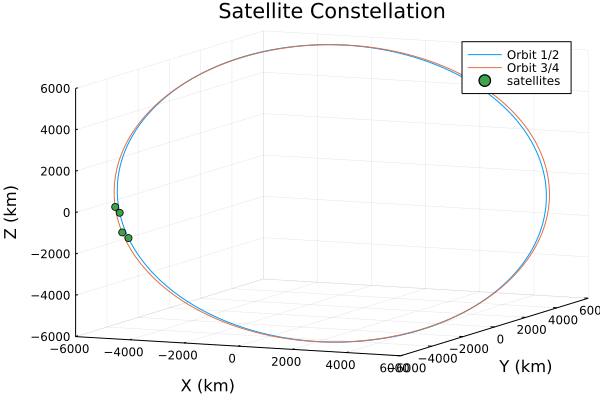

In [8]:
trueanom = 10
RAAN_sep = 2
delta_sep = 3
altitude = 800

orbit_update(trueanom, RAAN_sep, delta_sep, altitude)

In [ ]:
#@btime orbit_update($trueanom, $RAAN_sep, $delta_sep, $altitude) #run to test speed. currently at 6 ms

In [9]:
#create the sliders 

trueanom = slider(1:0.5:15; label="True Anomaly Seperation")
RAAN_sep = slider(1:0.5:5; label="RAAN Seperation between Orbits")
delta_sep = slider(1:0.5:10; label="Delta True Anomaly Seperation")
altitude = slider(400:100:1200; label="Orbit Altitude (km)")

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Orbit Altitude (km)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 9, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
5, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/fausto/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/fausto/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/fausto/.julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/home/fausto/.julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/home/fausto/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f4147242b60, Task (runnable) @0x00007f4147242b60), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"400\",\"500\",\"600\",\"700\",\"800\",\"900\",\"1000\",\"1100\",\"1200\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"13552621461245476112\",\"id\":\"4065110523409602215\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"13552621461245476112\",\"id\":\"563

In [10]:
mp = @manipulate for trueanom in trueanom, RAAN_sep in RAAN_sep, delta_sep in delta_sep, altitude in altitude
    orbit_update(trueanom, RAAN_sep, delta_sep, altitude)
    
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["True Anomaly Seperation"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 29, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
15, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/fausto/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/fausto/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/fausto/.julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/home/fausto/.julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/home/fausto/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f41435d9e40, Task (runnable) @0x00007f41435d9e40), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1.0\",\"1.5\",\"2.0\",\"2.5\",\"3.0\",\"3.5\",\"4.0\",\"4.5\",\"5.0\",\"5.5\",\"6.0\",\"6.5\",\"7.0\",\"7.5\",\"8.0\",\"8.5\",\"9.0\",\"9.5\",\"10.0\",\"10.5\",\"11.0\",\"11.5\",\"12.0\",\"12.5\",\"13.0\",\"13.5\",\"14.0\",\"14.5\",\"15.0\"],\"changes\"

In [ ]:
#Need to fix the axes in the intersection of x and y axes